![alternatvie text](https://www.doc.zuv.fau.de//M/FAU-Logo/01_FAU_Kernmarke/Web/FAU_Kernmarke_Q_RGB_blue.svg)


# Assignment 2: Visual Transformers
<center><img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png" alt="Alternative text"/></center> 
<center><figcaption>Fig 1. Dosovitskiy, Alexey, et al. "An image is worth 16x16 words: Transformers for image recognition at scale."https://arxiv.org/pdf/2010.11929.pdf. </figcaption></center>                 


In the lecture, transformers have been studied in the context of sequence-to-sequence modelling applications like natural language processing (NLP). Their superior performance to LSTM-based Recurrant neural network gained them a powerful reputation, thanks to their ability to model long sequences. A couple of years ago, transformers have been adapted to the [visual domain](https://arxiv.org/abs/2010.11929) and suprisingly demonstrated better performance compared to the long standing convolutional neural networks conditioned to large-scale datasets. Thanks to their ability to capture global semantic relationships in an image, unlike, CNNs which capture local information within the vicinty of the convolutional kernel window.

In this assignment, you'll be asked first to implement the building blocks of visual transformers (LightViT). Afterwards, you'll train them on classification task using MNIST and Fashion-MNIST datasets.


In [7]:
import torch
import torch.nn as nn

class LightViT(nn.Module):
  def __init__(self,image_dim, n_patches=7, n_blocks=2, d=8, n_heads=2, num_classes=10):
    super(LightViT, self).__init__()
    
    ## Class Members
    self.n_patches = n_patches
    patch_dim = image_dim // n_patches
    self.patch_dim = patch_dim
    ## 1B) Linear Mapping
    self.linear_map = nn.Linear(patch_dim * patch_dim,d)
    ## 2A) Learnable Parameter
    self.cls_token = nn.Parameter(torch.zeros(1,1,d))
    ## 2B) Positional embedding
    self.pos_embed = nn.Parameter(torch.zeros(1,n_patches * n_patches + 1,d));
    ## 3) Encoder blocks
    encoder_layer = nn.TransformerEncoderLayer(d_model=d,nhead=n_heads,batch_first=True)
    self.encoder = nn.TransformerEncoder(encoder_layer,num_layers=n_blocks)
    # 5) Classification Head
    self.classifier = nn.Linear(d,num_classes)
  
  def forward(self, images):
     batch_size = images.shape[0]
    ## Extract patches
     patches = images.unfold(2, self.patch_dim, self.patch_dim).unfold(3,self.patch_dim, self.patch_dim)
     patches = patches.contiguous().view(batch_size,1,self.n_patches,self.n_patches,self.patch_dim * self.patch_dim)
     patches = patches.view(batch_size, -1, self.patch_dim * self.patch_dim) 
    ## Linear mapping
     tokens = self.linear_map(patches)
    ## Add classification token
     cls_token = self.cls_token.expand(batch_size,-1,-1)
     tokens = torch.cat((cls_token,tokens),dim=1) 
    ## Add positional embeddings
     tokens = tokens + self.pos_embed
    ## Pass through encoder
     encoded = self.encoder(tokens)
    ## Get classification token
     cls_out = encoded[:,0,:]
    ## Pass through classifier
     out = self.classifier(cls_out)

     return out

## 1. Image Patches and Linear Mapping

### A) Image Patches
Transfomers were initially created to process sequential data. In case of images, a sequence can be created through extracting patches. To do so, a crop window should be used with a defined window height and width. The dimension of data is originally in the format of *(B,C,H,W)*, when transorfmed into patches and then flattened we get *(B, PxP, (HxC/P)x(WxC/P))*, where *B* is the batch size and *PxP* is total number of patches in an image. In this example, you can set P=7. 


*Output*: A function that extracts image patches. The output format should have a shape of (B,49,16). The function will be used inside *LightViT* class.

In [8]:
def patches(images, n_patches=7):
    B, C, H, W = images.shape
    patch_h = H // n_patches
    patch_w = W // n_patches

    patches = images.unfold(2, patch_h, patch_h).unfold(3, patch_w, patch_w)
    patches = patches.permute(0, 2, 3, 1, 4, 5)  

    patches = patches.reshape(B, n_patches * n_patches, -1)
    return patches

### B) Linear Mapping

Afterwards, the input are mapped using a linear layer to an output with dimension *d* i.e. *(B, PxP, (HxC/P)x(WxC/P))* &rarr; *(B, PxP, d)*. The variable d can be freely chosen, however, we set here to 8. 

*Output*: A linear layer should be added inside *LightViT* class with the correct input and output dimensions, the output from the linear layer should have a dimension of (B,49,8). 

## 2. Insert Classifier Token and Positional embeddings

### A) Classifier Token

Beside the image patches, also known as tokens, an additional special token is appended to the the input to capture desired information about other tokens to learn the task at hand. Lateron, this token will be used as input to the classifier to determine the class of the input image. To add the token to the input is equivilant to concatentating a learnable parameter with a vector of the same dimension *d* to the image tokens. 

*Output* A randomly initialised learnable parameter to be implemented inside *LightViT* class. You can use [PyTorch built-in function](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) to create a PyTorch parameter.

### B) Positional Embedding

To preserve the context of an image, positional embeddings are associated with each image patch. Positional embeddings encodes the patch positions using sinusoidal waves, however, there are other techniques. We follow the definition of positional encoding in the original transformer paper of [Vaswani et. al](https://arxiv.org/abs/1706.03762), which sinusoidal waves. You'll be required to implement a function that creates embeddings for each coordinate of every image patch. 

*Output* Inside *LightViT* class, implement a function that fetches the embedding and encapuslate it inside a non-learnable parameter.

In [3]:
def get_pos_embeddings(self, seq_len, d):
    pos = torch.arange(seq_len, dtype=torch.float).unsqueeze(1)
    i = torch.arange(d, dtype=torch.float).unsqueeze(0)
    angle_rates = 1 / torch.pow(10000, (2 * (i // 2)) / d)
    angle_rads = pos * angle_rates

    # apply sin to even indices in the array; cos to odd indices
    angle_rads[:, 0::2] = torch.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = torch.cos(angle_rads[:, 1::2])

    return angle_rads.unsqueeze(0)  # shape (1, seq_len, d)


## 3. Encoder Block

<center><img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" alt="Alternative text" width="400" height="500"/></center> 
<center><figcaption>Fig 2. Transformer Encoder."https://arxiv.org/pdf/2010.11929.pdf. </figcaption></center>  

This is the challenging part of the assignment as it will be required from you to implement the main elements of an encoder block. A single block contains layer normalization (LN), multi-head self-attention (MHSA), and a residual connection.  

### A) Layer Normalization
[Layer normailzation](https://arxiv.org/abs/1607.06450), similar to other techniques, normalizes an input across the layer dimension by subtracting mean and dividing by standard deviation. You can instantiate layer normalization which has a dimension *d* using [PyTorch built-in function](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
### B) MHSA
<center><img src="https://production-media.paperswithcode.com/methods/multi-head-attention_l1A3G7a.png" alt="Alternative text" width="300" height="400"/></center> 
<center><figcaption>Fig 2. Multi-Head Self Attention."https://arxiv.org/pdf/1706.03762v5.pdf. </figcaption></center>  
  
 The attention module derives an attention value by measuring similarity between one patch and the other patches. To this end, an image patch with dimension *d* is linearly mapped to three vectors; query **q**, key **k**, and value **v** , hence a distint linear layer should be instantiated to get each of the three vectors. To quantify attention for a single patch, first, the dot product is computed between its **q** and all of the **k** vectors and divide by the square root of the vector dimension i.e. *d* = 8. The result is passed through a softmax layer to get *attention features* and finally multiple with **v** vectors associated with each of the **k** vectors and sum up to get the result. This allows to get an attention vector for each patch by measuring its similarity with other patches.
 
  Note that this process should be repeated **N** times on each of the **H** sub-vectors of the 8-dimensional patch, where **N** is the total number of attention blocks. In our case, let **N** = 2, hence, we have 2 sub-vectors, each of length 4. The first sub-vector is processed by the first head and the second sub-vector is process by the second head, each head has distinct Q,K, and V mapping functions of size 4x4. 
 
 For more information about MHSA, you may refer to this [post](https://data-science-blog.com/blog/2021/04/07/multi-head-attention-mechanism/).
 
 It is highly recommended to define a seperate class for MHSA as it contains several operations.



In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MHSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MHSA, self).__init__()
        assert d % n_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.d = d
        self.n_heads = n_heads
        self.head_dim = d // n_heads

        # Linear layers for Q, K, V (each maps d -> d)
        self.q_proj = nn.Linear(d, d)
        self.k_proj = nn.Linear(d, d)
        self.v_proj = nn.Linear(d, d)

        # Final linear layer to combine heads
        self.out_proj = nn.Linear(d, d)

    def forward(self, sequences):
        # sequences: (B, seq_len, d)
        B, seq_len, _ = sequences.size()

        # Project input to Q, K, V
        Q = self.q_proj(sequences)  # (B, seq_len, d)
        K = self.k_proj(sequences)
        V = self.v_proj(sequences)

        # Split each Q/K/V into multiple heads
        Q = Q.view(B, seq_len, self.n_heads, self.head_dim).transpose(1, 2)  # (B, n_heads, seq_len, head_dim)
        K = K.view(B, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(B, seq_len, self.n_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (B, n_heads, seq_len, seq_len)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)  # (B, n_heads, seq_len, head_dim)

        # Concatenate heads
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, seq_len, self.d)  # (B, seq_len, d)

        # Final projection
        return self.out_proj(attn_output)  # (B, seq_len, d)


### C) Residual Connection

Residual connections (also know as skip connections) add the original input to the processed output by a network layer e.g. encoder. They have proven to be useful in deep neural networks as they mitigate problems like exploding / vanishing gradients. In transformer, the residual connection is adding the original input to the output from LN &rarr; MHSA. All of the previous operations could be implemented inside a seperate encoder class.

The last part of an encoder, is to a inser another residual connection between the input to the encoder and the output from the encoder passed through another layer of LN &rarr; MLP. The MLP consists of 2 layers with hidden size 4 times larger than *d*.

*output*: The output from a single encoder block should have the same dimension as input.

In [10]:
import torch
import torch.nn as nn

class ViTEncoder(nn.Module):
    def __init__(self, hidden_d, n_heads):
        super(ViTEncoder, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MHSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, 4 * hidden_d),
            nn.GELU(),
            nn.Linear(4 * hidden_d, hidden_d)
        )

    def forward(self, x):
        # First residual connection: x + MHSA(norm1(x))
        out = x + self.mhsa(self.norm1(x))

        # Second residual connection: out + MLP(norm2(out))
        out = out + self.mlp(self.norm2(out))
        
        return out


### C) Test Encoder
It is highly recommended to test the encoder with a tensor of random values as input.

In [11]:
if __name__ == '__main__':
  model = ViTEncoder(hidden_d=8, n_heads=2)

  x = torch.randn(7, 50, 8)  
  print(model(x).shape)

torch.Size([7, 50, 8])


## 4. Classification Head

The final part of implemeting a transformer is adding a classification head to the model inside *LightViT* class. You can simply use a linear classifier i.e. a linear layer that accepts input of dimension *d* and outputs logits with dimension set to the number of classes for the classification problem at hand.

## 5a. Model Train for MNIST

At this point you have completed the major challenge of the assignment. Now all you need to do is to implement a standard script for training and testing the model. We recommend to use Adam optimizer with 0.005 learning rate and train for 5 epochs.

In [12]:
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

# --- LightViT class must already be implemented before this block ---

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 5
LR = 0.005
NUM_CLASSES = 10
PATCH_SIZE = 7  # Since MNIST is 28x28 → 4x4 patches = 7x7 = 49 patches
EMBED_DIM = 8

# 1. Define Dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean & std
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 2. Define Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightViT(image_dim=28, n_patches=PATCH_SIZE, d=EMBED_DIM, num_classes=NUM_CLASSES)
model.to(device)

# 3. Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# 4. Define Loss
criterion = nn.CrossEntropyLoss()

# 5. Train
def train(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Train Loss: {total_loss / len(loader):.4f}")

# 6. Test
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total * 100
    print(f"Test Accuracy: {acc:.2f}%")

# 7. Run training loop
for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}")
    train(model, train_loader)
    test(model, test_loader)



Epoch 1
Train Loss: 1.5398
Test Accuracy: 61.13%

Epoch 2
Train Loss: 0.9842
Test Accuracy: 74.52%

Epoch 3
Train Loss: 0.7624
Test Accuracy: 84.26%

Epoch 4
Train Loss: 0.6544
Test Accuracy: 87.14%

Epoch 5
Train Loss: 0.5855
Test Accuracy: 87.90%


## 5b. Model Training for FashionMNIST
For this task you may reuse the LightViT transformer that you already implemented before. Plot the accuracies for various learning rates of $0.01,0.001,0.0001$ and select the best performing model.


Training with Learning Rate: 0.01
LR: 0.01 Epoch [1/5] Train Acc: 47.15% Test Acc: 66.06%
LR: 0.01 Epoch [2/5] Train Acc: 67.08% Test Acc: 73.19%
LR: 0.01 Epoch [3/5] Train Acc: 71.95% Test Acc: 75.52%
LR: 0.01 Epoch [4/5] Train Acc: 74.20% Test Acc: 77.49%
LR: 0.01 Epoch [5/5] Train Acc: 75.77% Test Acc: 78.70%

Training with Learning Rate: 0.001
LR: 0.001 Epoch [1/5] Train Acc: 45.27% Test Acc: 65.00%
LR: 0.001 Epoch [2/5] Train Acc: 63.14% Test Acc: 71.33%
LR: 0.001 Epoch [3/5] Train Acc: 68.26% Test Acc: 73.93%
LR: 0.001 Epoch [4/5] Train Acc: 70.84% Test Acc: 76.30%
LR: 0.001 Epoch [5/5] Train Acc: 73.06% Test Acc: 75.92%

Training with Learning Rate: 0.0001
LR: 0.0001 Epoch [1/5] Train Acc: 20.26% Test Acc: 36.59%
LR: 0.0001 Epoch [2/5] Train Acc: 44.52% Test Acc: 54.87%
LR: 0.0001 Epoch [3/5] Train Acc: 53.74% Test Acc: 61.82%
LR: 0.0001 Epoch [4/5] Train Acc: 58.63% Test Acc: 64.82%
LR: 0.0001 Epoch [5/5] Train Acc: 61.05% Test Acc: 66.95%


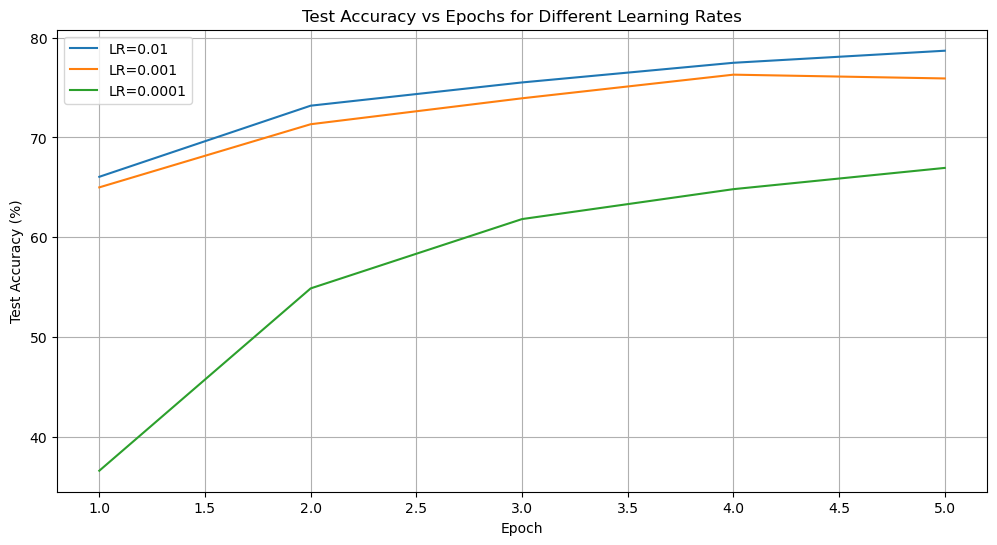

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1. Dataloader (FashionMNIST)
transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 64

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. Training Function
def train_and_test_model(lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = LightViT(image_dim=28, n_patches=7, n_blocks=2, d=8, n_heads=2, num_classes=10)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    n_epochs = 5
    train_accuracies = []
    test_accuracies = []

    for epoch in range(n_epochs):
        # Training Phase
        model.train()
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100. * correct / total
        train_accuracies.append(train_accuracy)

        # Testing Phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_accuracy = 100. * correct / total
        test_accuracies.append(test_accuracy)

        print(f'LR: {lr} Epoch [{epoch+1}/{n_epochs}] Train Acc: {train_accuracy:.2f}% Test Acc: {test_accuracy:.2f}%')

    return train_accuracies, test_accuracies

# 3. Train and Evaluate for Different Learning Rates
learning_rates = [0.01, 0.001, 0.0001]
results = {}

for lr in learning_rates:
    print(f'\nTraining with Learning Rate: {lr}')
    train_acc, test_acc = train_and_test_model(lr)
    results[lr] = {
        'train': train_acc,
        'test': test_acc
    }

# 4. Plot the Accuracies
plt.figure(figsize=(12, 6))

for lr in learning_rates:
    plt.plot(range(1, 6), results[lr]['test'], label=f'LR={lr}')

plt.title('Test Accuracy vs Epochs for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid()
plt.show()